# IMPORTS

In [1]:
import os
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from accelerate import Accelerator, notebook_launcher
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
aspect_accuracies = manager.list()
aspect_f1_micros = manager.list()
aspect_f1_macros = manager.list()
sentiment_accuracies = manager.list()
sentiment_f1_micros = manager.list()
sentiment_f1_macros = manager.list()
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()
farthest_point = manager.Value("s", "test")

# Non shared resources
filename = 'casa-mc-coreset'
epochs = 10
batch_size = 16
sequence_length = 48

aspect_list = ['fuel', 'machine', 'others', 'part', 'price', 'service']
aspect_mapping = {'fuel': 0, 'machine': 1, 'others': 2, 'part': 3, 'price': 4, 'service': 5 }
label_mapping = {"negative": 0, "neutral": 1, 'positive': 2}
ignored_keys = ['labels', 'ori_text', 'ori_label', 'ori_indices', 'aspect']

# LOAD AND PREPROCESS DATA

In [6]:
train_data = pd.read_csv('/kaggle/input/casa-dataset/train_preprocess.csv', encoding='latin-1')
val_data = pd.read_csv('/kaggle/input/casa-dataset/valid_preprocess.csv', encoding='latin-1')
test_data = pd.read_csv('/kaggle/input/casa-dataset/test_preprocess.csv', encoding='latin-1')

data = pd.concat([train_data, val_data, test_data], ignore_index=True)

data.head()

,sentence,fuel,machine,others,part,price,service
0,Saya memakai Honda Jazz GK5 tahun 2014 ( perta...,neutral,neutral,positive,neutral,neutral,neutral
1,Avanza kenapa jadi boros bensin begini dah ah....,negative,neutral,neutral,neutral,neutral,neutral
2,"saran ku dan pengalaman ku , mending beli mobi...",positive,positive,neutral,neutral,neutral,neutral
3,Dari segi harga juga pajero lebih mahal 30 jut...,neutral,neutral,neutral,neutral,positive,neutral
4,Kalo menurut gw enak pajero si,neutral,neutral,positive,neutral,neutral,neutral


In [7]:
data.head()

,sentence,fuel,machine,others,part,price,service
0,Saya memakai Honda Jazz GK5 tahun 2014 ( perta...,neutral,neutral,positive,neutral,neutral,neutral
1,Avanza kenapa jadi boros bensin begini dah ah....,negative,neutral,neutral,neutral,neutral,neutral
2,"saran ku dan pengalaman ku , mending beli mobi...",positive,positive,neutral,neutral,neutral,neutral
3,Dari segi harga juga pajero lebih mahal 30 jut...,neutral,neutral,neutral,neutral,positive,neutral
4,Kalo menurut gw enak pajero si,neutral,neutral,positive,neutral,neutral,neutral


In [8]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=False)

In [9]:
train_labels = train_data.columns[1:]
val_labels = val_data.columns[1:]

# Extract features and labels for training and validation
X_train = train_data['sentence'].values
y_train = train_data[train_labels].values
X_val = val_data['sentence'].values
y_val = val_data[val_labels].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(864,) (864, 6)
(216,) (216, 6)


# BUILD DATASET & DATALOADERS

In [10]:
class AspectDetectionDataset(Dataset):
    def __init__(self, texts, labels, label_mapping, tokenizer, max_length=sequence_length, use_float=True):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_float = use_float
        self.label_mapping = label_mapping

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        
        original_labels = [self.label_mapping[label] for label in self.labels[idx]]
        encoded_labels = [1 if label == 1 else 0 for label in original_labels]
        
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['ori_indices'] = idx
        item['ori_text'] = self.texts[idx]
        item['ori_label'] = torch.tensor(original_labels, dtype=torch.float)
        item['labels'] = torch.tensor(encoded_labels, dtype=torch.float if self.use_float else torch.long)
        
        return item

In [11]:
class SentimentAnalysisDataset(Dataset):
    def __init__(self, texts, labels, aspects, indices, label_mapping, tokenizer, max_length=96, use_float=True):
        self.texts = texts
        self.labels = labels
        self.aspects = aspects
        self.indices = indices
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_float = use_float
        self.label_mapping = label_mapping

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = aspect_token + ' ' + self.aspects[idx] + ' ' + review_token + ' ' + self.texts[idx] 
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')

        if isinstance(self.labels[idx], str):
            self.labels[idx] = self.label_mapping[self.labels[idx]]
        elif torch.is_tensor(self.labels[idx]):
            self.labels[idx] = int(self.labels[idx].item())

        encoded_label = 1 if self.labels[idx] == 2 else self.labels[idx]
        one_hot_label = F.one_hot(torch.tensor(encoded_label, dtype=torch.long), num_classes=2).float()

        item = {key: val.squeeze() for key, val in encoding.items()}
        item['aspect'] = self.aspects[idx]
        item['labels'] = one_hot_label
        item['ori_indices'] = self.indices[idx]
        item['ori_text'] = self.texts[idx]
        item['ori_label'] = torch.tensor(self.labels[idx], dtype=torch.long)

        return item

In [12]:
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
review_token = '[REVIEW]'
aspect_token = '[ASPECT]'
special_tokens_dict = {'additional_special_tokens': [review_token, aspect_token]}
num_added_tokens = tokenizer.add_special_tokens(special_tokens_dict)

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [13]:
def build_aspect_dataset(X_train, y_train, X_val, y_val, sequence_length, num_workers=4):
    train_dataset = AspectDetectionDataset(X_train, y_train, label_mapping, tokenizer, max_length=sequence_length)
    val_dataset = AspectDetectionDataset(X_val, y_val, label_mapping, tokenizer, max_length=sequence_length)
    
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers,
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers, 
    )

    return train_loader, val_loader, train_dataset, val_dataset

In [14]:
def build_sentiment_dataset(device, train_dataset, val_dataset, aspect_detection_model, tokenizer, max_length=sequence_length):
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4, 
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4, 
    )

    aspect_detection_model.to(device)
    aspect_detection_model.eval()

    train_data = []
    train_labels = []
    train_aspects = []
    train_indices = []

    val_data = []
    val_labels = []
    val_aspects = []
    val_indices = []

    # Transform train set
    start_time = time.time()
    with torch.no_grad():
        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels'].to(device)
            
            outputs = aspect_detection_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()

            for i in range(len(preds)):
                for j in range(len(preds[i])):
                    if int(preds[i][j]) != 1:
                        train_aspects.append(aspect_list[j])
                        train_data.append(batch['ori_text'][i])
                        train_labels.append(batch['ori_label'][i][j])
                        train_indices.append(batch['ori_indices'][i])
            
        # Transform validation set
        for batch in val_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels'].to(device)
            
            outputs = aspect_detection_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()

            for i in range(len(preds)):
                for j in range(len(preds[i])):
                    if int(preds[i][j]) != 1:
                        val_aspects.append(aspect_list[j])
                        val_data.append(batch['ori_text'][i])
                        val_labels.append(batch['ori_label'][i][j])
                        val_indices.append(batch['ori_indices'][i])

    train_dataset = SentimentAnalysisDataset(train_data, train_labels, train_aspects, train_indices, label_mapping, tokenizer, max_length=max_length)
    val_dataset = SentimentAnalysisDataset(val_data, val_labels, val_aspects, val_indices, label_mapping, tokenizer, max_length=max_length)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4, 
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4, 
    )

    return train_loader, val_loader, train_dataset, val_dataset

# TRAIN THE MODEL

In [15]:
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 25

In [16]:
def compute_metrics(p, label, classes):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    hamming_accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        labels=label,
        target_names=classes,
        zero_division=0
    ) 

    return {
        'accuracy': hamming_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [17]:
def compute_metrics_overall(p, classes):
    preds = torch.tensor(p.predictions)
    labels = torch.tensor(p.label_ids)

    # Ensure it's in the correct shape
    if preds.shape != labels.shape:
        raise ValueError("Shape mismatch: predictions and labels must have the same shape.")

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    hamming_accuracy = (preds == labels).float().mean().item()

    # Compute per-label (column-wise) precision, recall, F1
    precision_list, recall_list, f1_micro_list, f1_macro_list = [], [], [], []
    
    for i in range(labels.shape[1]):  # Loop through each column (multi-output)
        prec, rec, f1_micro, _ = precision_recall_fscore_support(
            labels[:, i], preds[:, i], average='micro', zero_division=0
        )
        _, _, f1_macro, _ = precision_recall_fscore_support(
            labels[:, i], preds[:, i], average='macro', zero_division=0
        )

        precision_list.append(prec)
        recall_list.append(rec)
        f1_micro_list.append(f1_micro)
        f1_macro_list.append(f1_macro)

    # Compute average metrics across all outputs
    precision = sum(precision_list) / len(precision_list)
    recall = sum(recall_list) / len(recall_list)
    f1_micro = sum(f1_micro_list) / len(f1_micro_list)
    f1_macro = sum(f1_macro_list) / len(f1_macro_list)

    # Generate classification report per output
    reports = [classification_report(labels[:, i], preds[:, i], target_names=classes, zero_division=0) for i in range(labels.shape[1])]

    return {
        'accuracy': hamming_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'reports': reports  # Returns list of reports, one for each output label
    }

In [18]:
def train_model(current_train_size, train_indices, aspect_metrics, sentiment_metrics, metrics, trials, seed):
    accelerator = Accelerator(mixed_precision='fp16')  # Initialize the accelerator
    device = accelerator.device

    aspect_model = BertForSequenceClassification.from_pretrained(
        'indobenchmark/indobert-base-p1',
        num_labels=len(train_labels),
        problem_type="multi_label_classification"
    )

    # Freeze the first few layers of the encoder
    for name, param in aspect_model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Define optimizer and loss function
    aspect_optimizer = torch.optim.AdamW(aspect_model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Define DataLoaders
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    aspect_train_loader, aspect_val_loader, aspect_train_dataset, aspect_val_dataset = build_aspect_dataset(current_X_train, current_y_train, X_val, y_val, sequence_length)

    # Prepare everything with Accelerator
    aspect_model, aspect_optimizer, aspect_train_loader, aspect_val_loader = accelerator.prepare(
        aspect_model, aspect_optimizer, aspect_train_loader, aspect_val_loader
    )

    nearest_cp = current_train_size
    if nearest_cp not in checkpoints:
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
    percentage = math.ceil(nearest_cp / total_data * 100)

    aspect_result = None
    start_time = time.time()

    # ASPECT DETECTION
    accelerator.print("ASPECT DETECTION")
    for epoch in range(epochs):
        aspect_model.train()
        epoch_loss = 0

        for batch in aspect_train_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels']
        
            aspect_optimizer.zero_grad()
            outputs = aspect_model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            aspect_optimizer.step()
        
            epoch_loss += loss.item()
            
        aspect_model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in aspect_val_loader:
                inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
                labels = batch['labels']
                
                outputs = aspect_model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(
            type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}),
            None,
            ['fuel', 'machine', 'others', 'part', 'price', 'service']
        )

        if aspect_result is None or result['f1_micro'] >= aspect_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(aspect_model)
            unwrapped_model.save_pretrained(
                f'{filename}-aspect-model-{percentage}',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            aspect_result = result

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(aspect_train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    accelerator.print(f"\nAspect detection accuracy: {round(aspect_result['accuracy'], 4)}, F1 Micro: {round(aspect_result['f1_micro'], 4)}, F1 Macro: {round(aspect_result['f1_macro'], 4)}")
    accelerator.print(aspect_result['report'])

    best_aspect_model = BertForSequenceClassification.from_pretrained(f'{filename}-aspect-model-{percentage}')
    best_aspect_model = accelerator.prepare(best_aspect_model)

    # SENTIMENT ANALYSIS ON NON NEUTRAL ASPECTS
    accelerator.print("--------------------------------------------------")
    accelerator.print("SENTIMENT ANALYSIS")

    sentiment_model = BertForSequenceClassification.from_pretrained(
        'indobenchmark/indobert-base-p1',
        num_labels=2,
    )
    sentiment_optimizer = torch.optim.AdamW(sentiment_model.parameters(), lr=2e-5, weight_decay=0.01)

    for name, param in sentiment_model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    accelerator.wait_for_everyone()
    sentiment_train_loader, sentiment_val_loader, sentiment_train_dataset, sentiment_val_dataset = build_sentiment_dataset(
        device, aspect_train_dataset, aspect_val_dataset, best_aspect_model, tokenizer, max_length=sequence_length
    )
    sentiment_model, sentiment_optimizer, sentiment_train_loader, sentiment_val_loader = accelerator.prepare(
        sentiment_model, sentiment_optimizer, sentiment_train_loader, sentiment_val_loader
    )
    sentiment_result = None

    for epoch in range(epochs):
        sentiment_model.train()
        epoch_loss = 0
        
        for batch in sentiment_train_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels']
        
            sentiment_optimizer.zero_grad()
            outputs = sentiment_model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            sentiment_optimizer.step()
        
            epoch_loss += loss.item()

        sentiment_model.eval()
        sentiment_val_outputs = []
        
        with torch.no_grad():
            for batch in sentiment_val_loader:
                inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
                
                outputs = sentiment_model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                for i in range(len(preds)):
                    val_output = {
                        'label': batch['labels'][i],
                        'aspect': batch['aspect'][i],
                        'ori_indices': batch['ori_indices'][i],
                        'pred': np.argmax(preds[i].cpu().numpy()),
                    }
                    sentiment_val_outputs.append(val_output)

        sentiment_val_outputs = accelerator.gather_for_metrics(sentiment_val_outputs)
        unique_val_outputs = {(x['ori_indices'].item(), x['aspect']): x for x in sentiment_val_outputs}
        sentiment_val_outputs = list(unique_val_outputs.values())

        result = compute_metrics(
            type('EvalOutput', (object,), {'predictions': [item['pred'] for item in sentiment_val_outputs], 'label_ids': [np.argmax(item['label'].cpu().numpy()) for item in sentiment_val_outputs]}),
            [0, 1],
            ['negative', 'positive']
        )

        if sentiment_result is None or result['f1_micro'] >= sentiment_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            sentiment_result = result
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(sentiment_model)
            unwrapped_model.save_pretrained(
                 f'{filename}-sentiment-model-{percentage}',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(sentiment_train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")
    
    end_time = time.time()
    duration = end_time - start_time

    accelerator.print(f"\nSentiment analysis accuracy: {round(sentiment_result['accuracy'], 4)}, F1 Micro: {round(sentiment_result['f1_micro'], 4)}, F1 Macro: {round(sentiment_result['f1_macro'], 4)}")
    accelerator.print(sentiment_result['report'])

    accelerator.wait_for_everyone()
    best_sentiment_model = BertForSequenceClassification.from_pretrained( f'{filename}-sentiment-model-{percentage}')
    best_sentiment_model = accelerator.prepare(best_sentiment_model)

    # Compute overall metrics
    aspect_labels = []
    aspect_indices = []
    aspect_preds = []

    aspect_outputs = {}
    sentiment_outputs = []
    
    best_aspect_model.eval()
    best_sentiment_model.eval()

    with torch.no_grad():
        for batch in aspect_val_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            outputs = best_aspect_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()

            aspect_indices.append(accelerator.gather(batch['ori_indices']))
            aspect_labels.append(accelerator.gather(batch['ori_label']))
            aspect_preds.append(accelerator.gather(preds))

        aspect_indices = torch.cat(aspect_indices).cpu().numpy()
        aspect_labels = torch.cat(aspect_labels).cpu().numpy()
        aspect_preds = torch.cat(aspect_preds).cpu().numpy()

        accelerator.wait_for_everyone()
        aspect_outputs = [
            {'ori_indices': aspect_indices[i], 
             'ori_labels': aspect_labels[i], 
             'pred': aspect_preds[i]}
            for i in range(len(aspect_preds))
        ]
        aspect_outputs = {x['ori_indices'].item(): x for x in aspect_outputs}
    
        for batch in sentiment_val_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            outputs = best_sentiment_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()
    
            for i in range(len(preds)):
                output = {
                    'aspect': batch['aspect'][i],
                    'ori_indices': batch['ori_indices'][i],
                    'pred': np.argmax(preds[i].cpu().numpy()),
                }
                sentiment_outputs.append(output)

        sentiment_outputs = accelerator.gather_for_metrics(sentiment_outputs)
        sentiment_outputs = {(x['ori_indices'].item(), x['aspect']): x for x in sentiment_outputs}

    # Replcae non neutral aspect to its predicted sentiment
    accelerator.wait_for_everyone()
    if accelerator.is_main_process:
        i = -1
        for (ori_index, aspect), value in sentiment_outputs.items():
            aspect = aspect_mapping[aspect]
            aspect_outputs[ori_index]['pred'][aspect] = 2 if value['pred'] == 1.0 else value['pred']

        result = compute_metrics_overall(
            type('EvalOutput', (object,), {'predictions': [output['pred'] for output in aspect_outputs.values()], 'label_ids': [output['ori_labels'] for output in aspect_outputs.values()]}),
            ['negative', 'neutral', 'positive'],
        )

        accelerator.print("--------------------------------------------------")
        accelerator.print(f"Iteration {current_train_size}: Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")
        accelerator.print("--------------------------------------------------")
        for i in range(len(train_labels)):
            accelerator.print(f"Aspect {aspect_list[i]} report:")
            accelerator.print(result['reports'][i])
       
        
        aspect_metrics[0].append(aspect_result['accuracy'])
        aspect_metrics[1].append(aspect_result['f1_micro'])
        aspect_metrics[2].append(aspect_result['f1_macro'])
        sentiment_metrics[0].append(sentiment_result['accuracy'])
        sentiment_metrics[1].append(sentiment_result['f1_micro'])
        sentiment_metrics[2].append(sentiment_result['f1_macro'])
        metrics[0].append(current_train_size)
        metrics[1].append(result['accuracy'])
        metrics[2].append(result['f1_micro'])
        metrics[3].append(result['f1_macro'])
        
    accelerator.print(f"Total train time: {duration} s")
    accelerator.end_training()
    return

# PLOT THE RESULTS

In [19]:
def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# QUERY STRATEGY

In [20]:
def combined_sampling(aspect_model, sentiment_model, farthest_point, X_pool, train_indices, remaining_indices, sampling_dur, new_samples, trials, n_samples=min_increment):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device

    aspect_model.to(device)
    aspect_model.eval()
    sentiment_model.to(device)
    sentiment_model.eval()

    current_train_size = len(train_indices)
    
    # Check nearest checkpoint
    nearest_cp = 0
    for cp in checkpoints:
        if cp > current_train_size:
            nearest_cp = cp
            break

    target_samples = math.ceil(0.1*len(remaining_indices))
    if target_samples <= min_increment and min_increment < nearest_cp - current_train_size:
        target_samples = min_increment
    elif target_samples > min_increment and target_samples < nearest_cp - current_train_size:
        target_samples = target_samples
    else:
        target_samples = nearest_cp - current_train_size

    final_cp = False
    if current_train_size >= checkpoints[-1] - target_samples:
        final_cp = True

        if accelerator.is_main_process:
            temp = train_indices.copy()
            temp.extend(remaining_indices)
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                'fuel': [y_train[i][0] for i in temp],
                'machine': [y_train[i][1] for i in temp],
                'others': [y_train[i][2] for i in temp],
                'part': [y_train[i][3] for i in temp],
                'price': [y_train[i][4] for i in temp],
                'service': [y_train[i][5] for i in temp],
            })
            acquired_data.to_csv(f'acquired_data/{filename}-data-{nearest_cp}.csv', index=False)
            
            print("Nearest checkpoint:", nearest_cp)
            print("Acquired samples:", len(remaining_indices))
            
            sampling_dur.append(0)
            for i in remaining_indices:
                new_samples.append(i)
                
    accelerator.wait_for_everyone()
    if not final_cp:
        aspect_dataset = AspectDetectionDataset(
            X_pool, 
            [['neutral' for i in range(len(train_labels))] for x in range(len(X_pool))], 
            label_mapping, 
            tokenizer, 
            max_length=sequence_length
        )
        aspect_loader = DataLoader(
            aspect_dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=4,
            pin_memory=True,
        )

        start_time = time.time()

        mc_indices = monte_carlo_dropout_sampling(aspect_model, sentiment_model, aspect_loader, device, target_samples)
        mc_indices = [remaining_indices[i] for i in mc_indices]
        accelerator.print(f"Got {len(mc_indices)} samples from mc")

        coreset_indices = coreset_sampling(aspect_model, sentiment_model, farthest_point, X_pool, device, target_samples)
        coreset_indices = [remaining_indices[i] for i in coreset_indices]
        accelerator.print(f"Got {len(coreset_indices)} samples from coreset")

        if accelerator.is_main_process:
            # Combine both methods' results
            combined_indices = list(set(mc_indices).union(set(coreset_indices)))
            
            # If we got more than we need, take only what we need
            if len(combined_indices) > target_samples:
                np.random.shuffle(combined_indices)
                combined_indices = combined_indices[:target_samples]
            
            # Calculate duration
            end_time = time.time()
            duration = end_time - start_time
            
            # Check if we've reached a checkpoint
            if current_train_size + len(combined_indices) >= nearest_cp:
                temp = train_indices.copy()
                temp.extend(combined_indices)
                
                # Save acquired data up to checkpoint
                acquired_data = pd.DataFrame({
                    'processed_text': [X_train[i] for i in temp],
                    'fuel': [y_train[i][0] for i in temp],
                    'machine': [y_train[i][1] for i in temp],
                    'others': [y_train[i][2] for i in temp],
                    'part': [y_train[i][3] for i in temp],
                    'price': [y_train[i][4] for i in temp],
                    'service': [y_train[i][5] for i in temp],
                })
                acquired_data.to_csv(f'acquired_data/{filename}-data-{nearest_cp}.csv', index=False)
            
            # Log results
            print("Nearest checkpoint:", nearest_cp)
            print(f"Acquired samples: {len(combined_indices)}")
            print(f"Sampling duration: {duration} seconds")
            
            sampling_dur.append(duration)
            for i in combined_indices:
                new_samples.append(i)

In [21]:
def monte_carlo_dropout_sampling(aspect_model, sentiment_model, aspect_loader, device, target_samples, mc_passes=3):
    aspect_outputs = {}
    sentiment_outputs = {}

    aspects = []
    data = []
    labels = []
    indices = []

    aspect_uncertainties = []

    # Pass through aspect detction model
    for batch in aspect_loader:
        token_type_ids = batch['token_type_ids'].to(device, non_blocking=True)
        input_ids = batch['input_ids'].to(device, non_blocking=True)
        attention_mask = batch['attention_mask'].to(device, non_blocking=True)

        batch_probs = []
        
        for i in range(mc_passes):
            with torch.no_grad():
                outputs = aspect_model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids).logits
                probs = torch.sigmoid(outputs).cpu().numpy()  # Shape: (batch_size, num_classes)
                batch_probs.append(probs)
                
        # Stack the probabilities from multiple MC passes
        batch_probs = np.stack(batch_probs, axis=0)  # Shape: (mc_passes, batch_size, num_classes)

        # Calculate mean probability and uncertainty for each sample in the batch
        mean_probs = np.mean(batch_probs, axis=0)  # Shape: (batch_size, num_classes)
        uncertainties = np.mean(np.var(batch_probs, axis=0), axis=1)  # Shape: (batch_size,)
        aspect_uncertainties.extend(uncertainties)

        for i in range(len(mean_probs)):
            aspect_outputs[batch['ori_indices'][i].item()] = [np.max(torch.sigmoid(outputs[i]).cpu().numpy())]
            
            for j in range(len(mean_probs[i])):
                if int(mean_probs[i][j].round()) != 1:
                    aspects.append(aspect_list[j])
                    data.append(batch['ori_text'][i])
                    labels.append(batch['ori_label'][i][j])
                    indices.append(batch['ori_indices'][i])

    aspect_outputs = {i: aspect_uncertainties[i] for i in range(len(aspect_uncertainties))}
    sentiment_dataset = SentimentAnalysisDataset(data, labels, aspects, indices, label_mapping, tokenizer, max_length=sequence_length)
    sentiment_loader = torch.utils.data.DataLoader(
        sentiment_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4,
    )

    # Pass through sentiment analysis model
    for batch in sentiment_loader:
        token_type_ids = batch['token_type_ids'].to(device, non_blocking=True)
        input_ids = batch['input_ids'].to(device, non_blocking=True)
        attention_mask = batch['attention_mask'].to(device, non_blocking=True)

        batch_probs = []
        for i in range(mc_passes):
            with torch.no_grad():
                outputs = sentiment_model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
                preds = torch.sigmoid(outputs.logits)

                for j in range(len(preds)):
                    ori_index = batch['ori_indices'][j].item()
                    if ori_index in sentiment_outputs.keys():
                        sentiment_outputs[ori_index].append(preds[j].cpu().numpy())
                    else:
                        sentiment_outputs[ori_index] = [preds[j].cpu().numpy()]

    for indices, probs in sentiment_outputs.items():
        sentiment_outputs[indices] = [[probs[i], probs[i+1], probs[i+2]] for i in range(int(len(probs) / 3))]
        
        variance = np.var(sentiment_outputs[indices], axis=1)
        mean_aspect_variance = np.mean(variance, axis=1)
        mean_data_variance = np.mean(mean_aspect_variance)
        
        sentiment_outputs[indices] = np.mean(np.mean(np.var(sentiment_outputs[indices], axis=0), axis=0), axis=0)

    aspect_outputs = dict(sorted(aspect_outputs.items()))
    if len(data) > 0:
        for key, val in sentiment_outputs.items():
            aspect_outputs[key] = (val + aspect_outputs[key]) / 2

    uncertainties = np.array(list(aspect_outputs.values()))
    sorted_unc = np.argsort(uncertainties)
    sorted_unc = sorted_unc[::-1]

    threshold = np.percentile(uncertainties, 90)
    least_confident_indices = sorted_unc[:target_samples]

    return least_confident_indices

In [22]:
def coreset_sampling(aspect_model, sentiment_model, farthest_point, X_pool, device, target_samples):
    farthest_data = farthest_point.value
    if farthest_data is not None:
        X_pool.append(farthest_data)

    aspect_dataset = AspectDetectionDataset(
        X_pool, 
        [['neutral' for i in range(len(train_labels))] for x in range(len(X_pool))], 
        label_mapping, 
        tokenizer, 
        max_length=sequence_length
    )
    aspect_loader = DataLoader(
        aspect_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True,
    )
    
    aspect_outputs = {}
    sentiment_outputs = {}

    aspects = []
    data = []
    labels = []
    indices = []

    # Pass through aspect detction model
    for batch in aspect_loader:
        token_type_ids = batch['token_type_ids'].to(device, non_blocking=True)
        input_ids = batch['input_ids'].to(device, non_blocking=True)
        attention_mask = batch['attention_mask'].to(device, non_blocking=True)
        
        with torch.no_grad():
            outputs = aspect_model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids).logits
            embeddings = aspect_model.base_model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

        for i in range(len(outputs)):
            aspect_outputs[batch['ori_indices'][i].item()] = embeddings.last_hidden_state[i].mean(dim=1).cpu().numpy()
            
            for j in range(len(outputs[i])):
                if int(outputs[i][j].round()) != 1:
                    aspects.append(aspect_list[j])
                    data.append(batch['ori_text'][i])
                    labels.append(batch['ori_label'][i][j])
                    indices.append(batch['ori_indices'][i])

    if len(data) > 0:
        sentiment_dataset = SentimentAnalysisDataset(data, labels, aspects, indices, label_mapping, tokenizer, max_length=sequence_length)
        sentiment_loader = torch.utils.data.DataLoader(
            sentiment_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4,
        )
    
        # Pass through sentiment analysis model
        for batch in sentiment_loader:
            token_type_ids = batch['token_type_ids'].to(device, non_blocking=True)
            input_ids = batch['input_ids'].to(device, non_blocking=True)
            attention_mask = batch['attention_mask'].to(device, non_blocking=True)
    
            with torch.no_grad():
                outputs = sentiment_model.base_model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
    
            for i in range(len(outputs.last_hidden_state)):
                ori_index = batch['ori_indices'][i].item()
                if ori_index in sentiment_outputs.keys():
                    sentiment_outputs[ori_index].append(outputs.last_hidden_state[i].mean(dim=1).cpu().numpy())
                else:
                    sentiment_outputs[ori_index] = [outputs.last_hidden_state[i].mean(dim=1).cpu().numpy()]

    for key, val in sentiment_outputs.items():
        sentiment_outputs[key] = np.mean(val, axis=0)

    collected_indices = set()  # Initialize set to store selected indices
    thresholds = []
    
    aspect_outputs = dict(sorted(aspect_outputs.items()))

    if len(data) > 0:
        for key, val in sentiment_outputs.items():
            aspect_outputs[key] = np.mean([val, aspect_outputs[key]], axis=0)

    embeddings = np.array(list(aspect_outputs.values()))
    distance_matrix = pairwise_distances(embeddings)
    selected_indices = distance_matrix.shape[0] - 1 if farthest_data is not None else 0

    # Calculate the minimum distance from selected points to all other points
    min_distances = distance_matrix[selected_indices]

    sorted_dist = np.argsort(min_distances)
    sorted_dist = sorted_dist[::-1]
    farthest_point.value = aspect_dataset[sorted_dist[0]]['ori_text']

    threshold = np.percentile(min_distances, 90)
    candidates = np.where(min_distances >= threshold)[0]  # Select the point farthest from the current set

    return sorted_dist[:target_samples]

# MAIN LOOP

In [23]:
def active_learning(seed, i):
    aspect_accuracies = manager.list()
    aspect_f1_micros = manager.list()
    aspect_f1_macros = manager.list()
    sentiment_accuracies = manager.list()
    sentiment_f1_micros = manager.list()
    sentiment_f1_macros = manager.list()
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_samples = manager.list()

    set_seed(seed)
    
    print("===============================================")
    print("TRIAL {}".format(i+1))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size
    
    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        # Train the model
        args = (
            current_train_size, 
            train_indices, 
            (aspect_accuracies, aspect_f1_micros, aspect_f1_macros), 
            (sentiment_accuracies, sentiment_f1_micros, sentiment_f1_macros),
            (data_used, accuracies, f1_micros, f1_macros), 
            i,
            seed
        )
        notebook_launcher(train_model, args, num_processes=2)

        nearest_cp = current_train_size
        if nearest_cp not in checkpoints:
            for cp in checkpoints:
                if cp > current_train_size:
                    nearest_cp = cp
                    break
        percentage = math.ceil(nearest_cp / total_data * 100)

        aspect_model = BertForSequenceClassification.from_pretrained(f'{filename}-aspect-model-{percentage}')
        sentiment_model = BertForSequenceClassification.from_pretrained(f'{filename}-sentiment-model-{percentage}')
    
        # Perform query strategy to select new samples
        new_samples = manager.list()
        sampling_args = (
            aspect_model, 
            sentiment_model, 
            farthest_point,
            [X_train[i] for i in remaining_indices], 
            train_indices, 
            remaining_indices, 
            sampling_dur, 
            new_samples, 
            i
        )
        notebook_launcher(combined_sampling, sampling_args, num_processes=2)
        new_samples = list(new_samples)
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    args = (
        current_train_size, 
        train_indices, 
        (aspect_accuracies, aspect_f1_micros, aspect_f1_macros), 
        (sentiment_accuracies, sentiment_f1_micros, sentiment_f1_macros),
        (data_used, accuracies, f1_micros, f1_macros), 
        i,
        seed
    )
    notebook_launcher(train_model, args, num_processes=2)
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
    aspect_accuracies, aspect_f1_micros, aspect_f1_macros = list(aspect_accuracies), list(aspect_f1_micros), list(aspect_f1_macros)
    sentiment_accuracies, sentiment_f1_micros, sentiment_f1_macros = list(sentiment_accuracies), list(sentiment_f1_micros), list(sentiment_f1_macros)
    
    end_time = time.time()
    duration = end_time - start_time
    
    # print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Aspect Accuracy': aspect_accuracies,
        'Aspect F1 Micro': aspect_f1_micros,
        'Aspect F1 Macro': aspect_f1_macros,
        'Sentiment Accuracy': sentiment_accuracies,
        'Sentiment F1 Micro': sentiment_f1_micros,
        'Sentiment F1 Macro': sentiment_f1_macros,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    
    sampling_dur.insert(0, 0)
    results['Sampling Duration'] = sampling_dur
    results.to_csv(f'results/{filename}-{i+1}-results.csv', index=False)

In [24]:
seeds = [50, 81, 14, 3, 94]

## RUN 1

TRIAL 1
Random seed: 50
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6756, Accuracy: 0.7731, F1 Micro: 0.8711, F1 Macro: 0.8698
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5958, Accuracy: 0.7887, F1 Micro: 0.8819, F1 Macro: 0.8804
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5785, Accuracy: 0.7932, F1 Micro: 0.8842, F1 Macro: 0.8827
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.513, Accuracy: 0.7939, F1 Micro: 0.8843, F1 Macro: 0.8828
Epoch 5/10, Train Loss: 0.5006, Accuracy: 0.7924, F1 Micro: 0.8829, F1 Macro: 0.881
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4695, Accuracy: 0.7954, F1 Micro: 0.8846, F1 Macro: 0.8828
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.4328, Accuracy: 0.7969, F1 Micro: 0.8857, F1 Macro: 0.8842
Epoch 8/10, Train Loss: 0.4369, Accuracy: 0.7932, F1 Micro: 0.8832, F1 Macro: 0.8812
Epoch 9/10, Train Loss: 0.415, Accuracy: 0.7917, F1 Micro: 0.8816, F1 Macro: 0.8789
Epoch 10/10, Train Loss

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.7162, Accuracy: 0.2857, F1 Micro: 0.2857, F1 Macro: 0.2222
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.6764, Accuracy: 0.5, F1 Micro: 0.5, F1 Macro: 0.4974
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.6621, Accuracy: 0.7143, F1 Micro: 0.7143, F1 Macro: 0.65
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.6053, Accuracy: 0.7857, F1 Micro: 0.7857, F1 Macro: 0.7143
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.5803, Accuracy: 0.7857, F1 Micro: 0.7857, F1 Macro: 0.7143
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.5674, Accuracy: 0.8571, F1 Micro: 0.8571, F1 Macro: 0.825
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.4789, Accuracy: 0.8571, F1 Micro: 0.8571, F1 Macro: 0.825
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.4895, Accuracy: 0.8571, F1 Micro: 0.8571, F1 Macro: 0.825
Epoch 9/10, Train Loss: 0.4054, Accuracy: 0.7143, F1 Micro: 0.7143,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6346, Accuracy: 0.7887, F1 Micro: 0.8819, F1 Macro: 0.8804
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5642, Accuracy: 0.7946, F1 Micro: 0.8848, F1 Macro: 0.8833
Epoch 3/10, Train Loss: 0.5156, Accuracy: 0.7924, F1 Micro: 0.8838, F1 Macro: 0.8823
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4832, Accuracy: 0.7954, F1 Micro: 0.8849, F1 Macro: 0.8832
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4625, Accuracy: 0.7976, F1 Micro: 0.8858, F1 Macro: 0.8841
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4154, Accuracy: 0.8036, F1 Micro: 0.8884, F1 Macro: 0.8867
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.4036, Accuracy: 0.8311, F1 Micro: 0.9016, F1 Macro: 0.8996
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3544, Accuracy: 0.8512, F1 Micro: 0.9119, F1 Macro: 0.9097
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2952, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6092, Accuracy: 0.7171, F1 Micro: 0.7171, F1 Macro: 0.4176
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5282, Accuracy: 0.7171, F1 Micro: 0.7171, F1 Macro: 0.4176
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4673, Accuracy: 0.8146, F1 Micro: 0.8146, F1 Macro: 0.7049
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3238, Accuracy: 0.922, F1 Micro: 0.922, F1 Macro: 0.9057
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2371, Accuracy: 0.922, F1 Micro: 0.922, F1 Macro: 0.9083
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1683, Accuracy: 0.9268, F1 Micro: 0.9268, F1 Macro: 0.9137
Epoch 7/10, Train Loss: 0.1351, Accuracy: 0.922, F1 Micro: 0.922, F1 Macro: 0.9083
Epoch 8/10, Train Loss: 0.1054, Accuracy: 0.9171, F1 Micro: 0.9171, F1 Macro: 0.903
Epoch 9/10, Train Loss: 0.0865, Accuracy: 0.922, F1 Micro: 0.922, F1 Macro: 0.9075
Epoch 10/10, Train Loss: 0.1299, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6145, Accuracy: 0.7917, F1 Micro: 0.8834, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5314, Accuracy: 0.7932, F1 Micro: 0.8842, F1 Macro: 0.8827
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.501, Accuracy: 0.7984, F1 Micro: 0.8866, F1 Macro: 0.8851
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4556, Accuracy: 0.8028, F1 Micro: 0.8883, F1 Macro: 0.8868
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4231, Accuracy: 0.8304, F1 Micro: 0.9022, F1 Macro: 0.901
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3652, Accuracy: 0.8899, F1 Micro: 0.9334, F1 Macro: 0.9319
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3169, Accuracy: 0.9055, F1 Micro: 0.9423, F1 Macro: 0.9407
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2665, Accuracy: 0.9182, F1 Micro: 0.949, F1 Macro: 0.9463
Higher F1 achieved, saving model
Epoch 9/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6182, Accuracy: 0.7051, F1 Micro: 0.7051, F1 Macro: 0.4135
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4641, Accuracy: 0.8205, F1 Micro: 0.8205, F1 Macro: 0.7504
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3471, Accuracy: 0.8718, F1 Micro: 0.8718, F1 Macro: 0.8584
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2815, Accuracy: 0.9103, F1 Micro: 0.9103, F1 Macro: 0.898
Epoch 5/10, Train Loss: 0.1712, Accuracy: 0.9017, F1 Micro: 0.9017, F1 Macro: 0.8891
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1377, Accuracy: 0.9188, F1 Micro: 0.9188, F1 Macro: 0.9065
Epoch 7/10, Train Loss: 0.1238, Accuracy: 0.9145, F1 Micro: 0.9145, F1 Macro: 0.9012
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1149, Accuracy: 0.9188, F1 Micro: 0.9188, F1 Macro: 0.9071
Epoch 9/10, Train Loss: 0.0692, Accuracy: 0.9103, F1 Micro: 0.9103, F1 Macro: 0.8973
Epoch 10/10, Train Loss: 0.1239, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5977, Accuracy: 0.7946, F1 Micro: 0.8843, F1 Macro: 0.8826
Epoch 2/10, Train Loss: 0.5389, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5066, Accuracy: 0.8043, F1 Micro: 0.8893, F1 Macro: 0.8879
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4364, Accuracy: 0.8207, F1 Micro: 0.8978, F1 Macro: 0.8963
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3712, Accuracy: 0.901, F1 Micro: 0.9398, F1 Macro: 0.9382
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.313, Accuracy: 0.9308, F1 Micro: 0.9571, F1 Macro: 0.9554
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2435, Accuracy: 0.9412, F1 Micro: 0.9632, F1 Macro: 0.9613
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1941, Accuracy: 0.9509, F1 Micro: 0.9696, F1 Macro: 0.968
Epoch 9/10, Train Loss: 0.1582, Accuracy: 0.9494, F1 Micro: 0.9683, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5534, Accuracy: 0.6681, F1 Micro: 0.6681, F1 Macro: 0.4005
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4205, Accuracy: 0.8253, F1 Micro: 0.8253, F1 Macro: 0.7742
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2793, Accuracy: 0.8996, F1 Micro: 0.8996, F1 Macro: 0.8864
Epoch 4/10, Train Loss: 0.1895, Accuracy: 0.8952, F1 Micro: 0.8952, F1 Macro: 0.8888
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2109, Accuracy: 0.8996, F1 Micro: 0.8996, F1 Macro: 0.8822
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1532, Accuracy: 0.9345, F1 Micro: 0.9345, F1 Macro: 0.9277
Epoch 7/10, Train Loss: 0.144, Accuracy: 0.917, F1 Micro: 0.917, F1 Macro: 0.9055
Epoch 8/10, Train Loss: 0.1621, Accuracy: 0.9214, F1 Micro: 0.9214, F1 Macro: 0.915
Epoch 9/10, Train Loss: 0.136, Accuracy: 0.9214, F1 Micro: 0.9214, F1 Macro: 0.9108
Epoch 10/10, Train Loss: 0.0993, Accuracy: 0.917, F1 Micro: 0.917, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6071, Accuracy: 0.7961, F1 Micro: 0.8855, F1 Macro: 0.8841
Epoch 2/10, Train Loss: 0.5424, Accuracy: 0.7939, F1 Micro: 0.8845, F1 Macro: 0.8831
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4841, Accuracy: 0.8177, F1 Micro: 0.8957, F1 Macro: 0.8951
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4162, Accuracy: 0.8854, F1 Micro: 0.9307, F1 Macro: 0.9296
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3297, Accuracy: 0.9278, F1 Micro: 0.9549, F1 Macro: 0.9528
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2652, Accuracy: 0.9479, F1 Micro: 0.9676, F1 Macro: 0.9662
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2099, Accuracy: 0.9516, F1 Micro: 0.9698, F1 Macro: 0.9678
Epoch 8/10, Train Loss: 0.1697, Accuracy: 0.9516, F1 Micro: 0.9695, F1 Macro: 0.9669
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1358, Accuracy: 0.9576, F1 Micro: 0.9734, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5284, Accuracy: 0.6822, F1 Micro: 0.6822, F1 Macro: 0.4055
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3441, Accuracy: 0.9031, F1 Micro: 0.9031, F1 Macro: 0.8907
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2219, Accuracy: 0.9186, F1 Micro: 0.9186, F1 Macro: 0.9087
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1346, Accuracy: 0.9186, F1 Micro: 0.9186, F1 Macro: 0.9087
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1312, Accuracy: 0.9302, F1 Micro: 0.9302, F1 Macro: 0.9206
Epoch 6/10, Train Loss: 0.1345, Accuracy: 0.9264, F1 Micro: 0.9264, F1 Macro: 0.9187
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0902, Accuracy: 0.9302, F1 Micro: 0.9302, F1 Macro: 0.9201
Epoch 8/10, Train Loss: 0.0804, Accuracy: 0.9147, F1 Micro: 0.9147, F1 Macro: 0.9062
Epoch 9/10, Train Loss: 0.1126, Accuracy: 0.9109, F1 Micro: 0.9109, F1 Macro: 0.9011
Epoch 10/10, Train Loss: 0.0801, Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5975, Accuracy: 0.7939, F1 Micro: 0.8845, F1 Macro: 0.8831
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5099, Accuracy: 0.7939, F1 Micro: 0.8845, F1 Macro: 0.8831
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4633, Accuracy: 0.8475, F1 Micro: 0.9112, F1 Macro: 0.9106
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3722, Accuracy: 0.9144, F1 Micro: 0.9471, F1 Macro: 0.9448
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2867, Accuracy: 0.9397, F1 Micro: 0.9627, F1 Macro: 0.9611
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2143, Accuracy: 0.9516, F1 Micro: 0.9699, F1 Macro: 0.9684
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1662, Accuracy: 0.9606, F1 Micro: 0.9755, F1 Macro: 0.9743
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1324, Accuracy: 0.9635, F1 Micro: 0.9772, F1 Macro: 0.9761
Epoch 9/10, Train Loss: 0.106, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4977, Accuracy: 0.6639, F1 Micro: 0.6639, F1 Macro: 0.399
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3399, Accuracy: 0.9016, F1 Micro: 0.9016, F1 Macro: 0.8917
Epoch 3/10, Train Loss: 0.1735, Accuracy: 0.8934, F1 Micro: 0.8934, F1 Macro: 0.8866
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1352, Accuracy: 0.9057, F1 Micro: 0.9057, F1 Macro: 0.8995
Epoch 5/10, Train Loss: 0.0994, Accuracy: 0.8852, F1 Micro: 0.8852, F1 Macro: 0.8789
Epoch 6/10, Train Loss: 0.123, Accuracy: 0.9016, F1 Micro: 0.9016, F1 Macro: 0.8939
Epoch 7/10, Train Loss: 0.1045, Accuracy: 0.9016, F1 Micro: 0.9016, F1 Macro: 0.8949
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1132, Accuracy: 0.9139, F1 Micro: 0.9139, F1 Macro: 0.9065
Epoch 9/10, Train Loss: 0.1283, Accuracy: 0.9057, F1 Micro: 0.9057, F1 Macro: 0.899
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0812, Accuracy: 0.9139, F1 Micro: 0.9139, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5878, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5192, Accuracy: 0.8125, F1 Micro: 0.8935, F1 Macro: 0.8927
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4341, Accuracy: 0.8876, F1 Micro: 0.9324, F1 Macro: 0.9317
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3514, Accuracy: 0.9226, F1 Micro: 0.9527, F1 Macro: 0.9507
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2825, Accuracy: 0.9487, F1 Micro: 0.968, F1 Macro: 0.9662
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2123, Accuracy: 0.9568, F1 Micro: 0.973, F1 Macro: 0.9713
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1618, Accuracy: 0.9583, F1 Micro: 0.9737, F1 Macro: 0.9718
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1315, Accuracy: 0.9621, F1 Micro: 0.9762, F1 Macro: 0.9744
Epoch 9/10, Train Loss: 0.1082, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5759, Accuracy: 0.7054, F1 Micro: 0.7054, F1 Macro: 0.5424
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2892, Accuracy: 0.8527, F1 Micro: 0.8527, F1 Macro: 0.846
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1932, Accuracy: 0.938, F1 Micro: 0.938, F1 Macro: 0.9306
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1602, Accuracy: 0.938, F1 Micro: 0.938, F1 Macro: 0.9302
Epoch 5/10, Train Loss: 0.1853, Accuracy: 0.9031, F1 Micro: 0.9031, F1 Macro: 0.8952
Epoch 6/10, Train Loss: 0.1106, Accuracy: 0.9225, F1 Micro: 0.9225, F1 Macro: 0.9151
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1214, Accuracy: 0.938, F1 Micro: 0.938, F1 Macro: 0.9302
Epoch 8/10, Train Loss: 0.1142, Accuracy: 0.9031, F1 Micro: 0.9031, F1 Macro: 0.8956
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0958, Accuracy: 0.9419, F1 Micro: 0.9419, F1 Macro: 0.9336
Higher F1 achieved, saving model
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5766, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5162, Accuracy: 0.8095, F1 Micro: 0.8921, F1 Macro: 0.891
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4301, Accuracy: 0.9159, F1 Micro: 0.9484, F1 Macro: 0.9467
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3361, Accuracy: 0.9375, F1 Micro: 0.9613, F1 Macro: 0.9599
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2535, Accuracy: 0.9546, F1 Micro: 0.9717, F1 Macro: 0.9702
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1887, Accuracy: 0.9598, F1 Micro: 0.975, F1 Macro: 0.9735
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1423, Accuracy: 0.9635, F1 Micro: 0.9772, F1 Macro: 0.9758
Epoch 8/10, Train Loss: 0.1144, Accuracy: 0.9598, F1 Micro: 0.9748, F1 Macro: 0.9732
Epoch 9/10, Train Loss: 0.0944, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5276, Accuracy: 0.7597, F1 Micro: 0.7597, F1 Macro: 0.6745
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.336, Accuracy: 0.8992, F1 Micro: 0.8992, F1 Macro: 0.8907
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2142, Accuracy: 0.9535, F1 Micro: 0.9535, F1 Macro: 0.9474
Epoch 4/10, Train Loss: 0.1516, Accuracy: 0.9109, F1 Micro: 0.9109, F1 Macro: 0.9031
Epoch 5/10, Train Loss: 0.123, Accuracy: 0.9186, F1 Micro: 0.9186, F1 Macro: 0.9111
Epoch 6/10, Train Loss: 0.1094, Accuracy: 0.938, F1 Micro: 0.938, F1 Macro: 0.931
Epoch 7/10, Train Loss: 0.1336, Accuracy: 0.9302, F1 Micro: 0.9302, F1 Macro: 0.9232
Epoch 8/10, Train Loss: 0.0748, Accuracy: 0.938, F1 Micro: 0.938, F1 Macro: 0.9314
Epoch 9/10, Train Loss: 0.0781, Accuracy: 0.907, F1 Micro: 0.907, F1 Macro: 0.8991
Epoch 10/10, Train Loss: 0.0595, Accuracy: 0.938, F1 Micro: 0.938, F1 Macro: 0.931

Sentiment analysis accuracy: 0.9535, F1 Micro: 0.9535, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5751, Accuracy: 0.7917, F1 Micro: 0.8834, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4963, Accuracy: 0.8132, F1 Micro: 0.8942, F1 Macro: 0.8932
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3897, Accuracy: 0.9249, F1 Micro: 0.9539, F1 Macro: 0.9528
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2782, Accuracy: 0.9494, F1 Micro: 0.9685, F1 Macro: 0.9668
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1977, Accuracy: 0.9583, F1 Micro: 0.9739, F1 Macro: 0.9724
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1522, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9771
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1254, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9784
Epoch 8/10, Train Loss: 0.103, Accuracy: 0.9606, F1 Micro: 0.9752, F1 Macro: 0.9737
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0813, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5217, Accuracy: 0.8755, F1 Micro: 0.8755, F1 Macro: 0.8639
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2704, Accuracy: 0.9183, F1 Micro: 0.9183, F1 Macro: 0.9074
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1711, Accuracy: 0.9261, F1 Micro: 0.9261, F1 Macro: 0.9157
Epoch 4/10, Train Loss: 0.168, Accuracy: 0.9066, F1 Micro: 0.9066, F1 Macro: 0.8887
Epoch 5/10, Train Loss: 0.1573, Accuracy: 0.9222, F1 Micro: 0.9222, F1 Macro: 0.9141
Epoch 6/10, Train Loss: 0.1419, Accuracy: 0.9183, F1 Micro: 0.9183, F1 Macro: 0.9109
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1287, Accuracy: 0.93, F1 Micro: 0.93, F1 Macro: 0.9227
Epoch 8/10, Train Loss: 0.0784, Accuracy: 0.9144, F1 Micro: 0.9144, F1 Macro: 0.9069
Epoch 9/10, Train Loss: 0.072, Accuracy: 0.9144, F1 Micro: 0.9144, F1 Macro: 0.906
Epoch 10/10, Train Loss: 0.0569, Accuracy: 0.9144, F1 Micro: 0.9144, F1 Macro: 0.8988

Sentiment analysis accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5644, Accuracy: 0.7932, F1 Micro: 0.8842, F1 Macro: 0.8827
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4964, Accuracy: 0.8095, F1 Micro: 0.8922, F1 Macro: 0.8911
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3877, Accuracy: 0.9129, F1 Micro: 0.9466, F1 Macro: 0.9453
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3027, Accuracy: 0.9472, F1 Micro: 0.967, F1 Macro: 0.9651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2136, Accuracy: 0.9576, F1 Micro: 0.9735, F1 Macro: 0.9722
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1613, Accuracy: 0.9606, F1 Micro: 0.9753, F1 Macro: 0.9742
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.122, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9773
Epoch 8/10, Train Loss: 0.1032, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9761
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.084, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5189, Accuracy: 0.8716, F1 Micro: 0.8716, F1 Macro: 0.8613
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2668, Accuracy: 0.9222, F1 Micro: 0.9222, F1 Macro: 0.9149
Epoch 3/10, Train Loss: 0.1509, Accuracy: 0.8949, F1 Micro: 0.8949, F1 Macro: 0.8884
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1535, Accuracy: 0.9261, F1 Micro: 0.9261, F1 Macro: 0.9167
Epoch 5/10, Train Loss: 0.1304, Accuracy: 0.8833, F1 Micro: 0.8833, F1 Macro: 0.8768
Epoch 6/10, Train Loss: 0.122, Accuracy: 0.9183, F1 Micro: 0.9183, F1 Macro: 0.9117
Epoch 7/10, Train Loss: 0.0814, Accuracy: 0.9144, F1 Micro: 0.9144, F1 Macro: 0.9082
Epoch 8/10, Train Loss: 0.1049, Accuracy: 0.9222, F1 Micro: 0.9222, F1 Macro: 0.9136
Epoch 9/10, Train Loss: 0.0723, Accuracy: 0.9222, F1 Micro: 0.9222, F1 Macro: 0.9153
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0684, Accuracy: 0.9261, F1 Micro: 0.9261, F1 Macro: 0.9198

Sentiment analysi

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5684, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4772, Accuracy: 0.8185, F1 Micro: 0.8969, F1 Macro: 0.8958
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3771, Accuracy: 0.9278, F1 Micro: 0.9555, F1 Macro: 0.9542
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2593, Accuracy: 0.9509, F1 Micro: 0.9696, F1 Macro: 0.9683
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1839, Accuracy: 0.9613, F1 Micro: 0.9759, F1 Macro: 0.9745
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1503, Accuracy: 0.9628, F1 Micro: 0.9768, F1 Macro: 0.9756
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1097, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.976
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0919, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macro: 0.9764
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5615, Accuracy: 0.6977, F1 Micro: 0.6977, F1 Macro: 0.4841
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2719, Accuracy: 0.8915, F1 Micro: 0.8915, F1 Macro: 0.8834
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1709, Accuracy: 0.938, F1 Micro: 0.938, F1 Macro: 0.931
Epoch 4/10, Train Loss: 0.1655, Accuracy: 0.9264, F1 Micro: 0.9264, F1 Macro: 0.9196
Epoch 5/10, Train Loss: 0.1186, Accuracy: 0.9302, F1 Micro: 0.9302, F1 Macro: 0.9236
Epoch 6/10, Train Loss: 0.1271, Accuracy: 0.9302, F1 Micro: 0.9302, F1 Macro: 0.9232
Epoch 7/10, Train Loss: 0.1112, Accuracy: 0.9264, F1 Micro: 0.9264, F1 Macro: 0.9192
Epoch 8/10, Train Loss: 0.1091, Accuracy: 0.9302, F1 Micro: 0.9302, F1 Macro: 0.9236
Epoch 9/10, Train Loss: 0.0703, Accuracy: 0.9264, F1 Micro: 0.9264, F1 Macro: 0.9199
Epoch 10/10, Train Loss: 0.0727, Accuracy: 0.9341, F1 Micro: 0.9341, F1 Macro: 0.9261

Sentiment analysis accuracy: 0.938, F1 Micro: 0.938,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5656, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4774, Accuracy: 0.8207, F1 Micro: 0.8976, F1 Macro: 0.8964
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3627, Accuracy: 0.9286, F1 Micro: 0.9556, F1 Macro: 0.9538
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2492, Accuracy: 0.9561, F1 Micro: 0.9728, F1 Macro: 0.9715
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1858, Accuracy: 0.9621, F1 Micro: 0.9761, F1 Macro: 0.9748
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1373, Accuracy: 0.9673, F1 Micro: 0.9795, F1 Macro: 0.9785
Epoch 7/10, Train Loss: 0.1132, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9779
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0899, Accuracy: 0.9688, F1 Micro: 0.9803, F1 Macro: 0.9792
Epoch 9/10, Train Loss: 0.0735, Accuracy: 0.9673, F1 Micro: 0.9794, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5332, Accuracy: 0.8161, F1 Micro: 0.8161, F1 Macro: 0.7516
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2344, Accuracy: 0.9119, F1 Micro: 0.9119, F1 Macro: 0.9046
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2135, Accuracy: 0.9349, F1 Micro: 0.9349, F1 Macro: 0.9273
Epoch 4/10, Train Loss: 0.143, Accuracy: 0.9272, F1 Micro: 0.9272, F1 Macro: 0.9201
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1309, Accuracy: 0.9349, F1 Micro: 0.9349, F1 Macro: 0.9288
Epoch 6/10, Train Loss: 0.1057, Accuracy: 0.931, F1 Micro: 0.931, F1 Macro: 0.9229
Epoch 7/10, Train Loss: 0.0606, Accuracy: 0.931, F1 Micro: 0.931, F1 Macro: 0.9245
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0768, Accuracy: 0.9349, F1 Micro: 0.9349, F1 Macro: 0.9285
Epoch 9/10, Train Loss: 0.0535, Accuracy: 0.9234, F1 Micro: 0.9234, F1 Macro: 0.9161
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0461, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5566, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4838, Accuracy: 0.8274, F1 Micro: 0.9013, F1 Macro: 0.9001
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3444, Accuracy: 0.9368, F1 Micro: 0.9607, F1 Macro: 0.959
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.24, Accuracy: 0.9561, F1 Micro: 0.9728, F1 Macro: 0.9717
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1765, Accuracy: 0.9621, F1 Micro: 0.9761, F1 Macro: 0.9746
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1323, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9766
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.105, Accuracy: 0.9695, F1 Micro: 0.9808, F1 Macro: 0.9796
Epoch 8/10, Train Loss: 0.087, Accuracy: 0.9621, F1 Micro: 0.9761, F1 Macro: 0.9745
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0725, Accuracy: 0.97

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5145, Accuracy: 0.9062, F1 Micro: 0.9062, F1 Macro: 0.893
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2603, Accuracy: 0.9414, F1 Micro: 0.9414, F1 Macro: 0.9359
Epoch 3/10, Train Loss: 0.1863, Accuracy: 0.9258, F1 Micro: 0.9258, F1 Macro: 0.9196
Epoch 4/10, Train Loss: 0.1646, Accuracy: 0.9336, F1 Micro: 0.9336, F1 Macro: 0.9258
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1434, Accuracy: 0.9453, F1 Micro: 0.9453, F1 Macro: 0.9394
Epoch 6/10, Train Loss: 0.0887, Accuracy: 0.9336, F1 Micro: 0.9336, F1 Macro: 0.9277
Epoch 7/10, Train Loss: 0.1096, Accuracy: 0.9297, F1 Micro: 0.9297, F1 Macro: 0.9233
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0768, Accuracy: 0.9453, F1 Micro: 0.9453, F1 Macro: 0.9387
Epoch 9/10, Train Loss: 0.0711, Accuracy: 0.9336, F1 Micro: 0.9336, F1 Macro: 0.9262
Epoch 10/10, Train Loss: 0.0588, Accuracy: 0.9258, F1 Micro: 0.9258, F1 Macro: 0.9166

Sentiment analysi

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5482, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4705, Accuracy: 0.8661, F1 Micro: 0.9207, F1 Macro: 0.9201
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.339, Accuracy: 0.9442, F1 Micro: 0.9654, F1 Macro: 0.9636
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2337, Accuracy: 0.9576, F1 Micro: 0.9736, F1 Macro: 0.9719
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1575, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.9759
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1285, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9766
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1, Accuracy: 0.9665, F1 Micro: 0.9791, F1 Macro: 0.9781
Epoch 8/10, Train Loss: 0.0828, Accuracy: 0.9643, F1 Micro: 0.9774, F1 Macro: 0.9758
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0689, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4761, Accuracy: 0.9173, F1 Micro: 0.9173, F1 Macro: 0.9111
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2389, Accuracy: 0.9173, F1 Micro: 0.9173, F1 Macro: 0.9115
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1563, Accuracy: 0.9409, F1 Micro: 0.9409, F1 Macro: 0.9356
Epoch 4/10, Train Loss: 0.1736, Accuracy: 0.937, F1 Micro: 0.937, F1 Macro: 0.9318
Epoch 5/10, Train Loss: 0.1422, Accuracy: 0.937, F1 Micro: 0.937, F1 Macro: 0.9289
Epoch 6/10, Train Loss: 0.1318, Accuracy: 0.9213, F1 Micro: 0.9213, F1 Macro: 0.9152
Epoch 7/10, Train Loss: 0.1072, Accuracy: 0.9331, F1 Micro: 0.9331, F1 Macro: 0.9246
Epoch 8/10, Train Loss: 0.09, Accuracy: 0.937, F1 Micro: 0.937, F1 Macro: 0.9312
Epoch 9/10, Train Loss: 0.0593, Accuracy: 0.9331, F1 Micro: 0.9331, F1 Macro: 0.9246
Epoch 10/10, Train Loss: 0.0622, Accuracy: 0.9291, F1 Micro: 0.9291, F1 Macro: 0.9195

Sentiment analysis accuracy: 0.9409, F1 Micro: 0.9409, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5519, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4673, Accuracy: 0.8594, F1 Micro: 0.9176, F1 Macro: 0.9164
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3319, Accuracy: 0.939, F1 Micro: 0.9618, F1 Macro: 0.9596
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2183, Accuracy: 0.9531, F1 Micro: 0.9706, F1 Macro: 0.9688
Epoch 5/10, Train Loss: 0.1732, Accuracy: 0.9524, F1 Micro: 0.97, F1 Macro: 0.9676
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1246, Accuracy: 0.9673, F1 Micro: 0.9795, F1 Macro: 0.9784
Epoch 7/10, Train Loss: 0.0938, Accuracy: 0.9658, F1 Micro: 0.9786, F1 Macro: 0.9774
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0763, Accuracy: 0.9695, F1 Micro: 0.9808, F1 Macro: 0.9797
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0633, Accuracy: 0.9725, F1 Micro: 0.9827, F1 Macro: 0.9818
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5135, Accuracy: 0.9023, F1 Micro: 0.9023, F1 Macro: 0.8952
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2457, Accuracy: 0.9414, F1 Micro: 0.9414, F1 Macro: 0.9359
Epoch 3/10, Train Loss: 0.1592, Accuracy: 0.9258, F1 Micro: 0.9258, F1 Macro: 0.92
Epoch 4/10, Train Loss: 0.1249, Accuracy: 0.9258, F1 Micro: 0.9258, F1 Macro: 0.92
Epoch 5/10, Train Loss: 0.1363, Accuracy: 0.9258, F1 Micro: 0.9258, F1 Macro: 0.9166
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0878, Accuracy: 0.9414, F1 Micro: 0.9414, F1 Macro: 0.9356
Epoch 7/10, Train Loss: 0.096, Accuracy: 0.9336, F1 Micro: 0.9336, F1 Macro: 0.9277
Epoch 8/10, Train Loss: 0.0697, Accuracy: 0.9297, F1 Micro: 0.9297, F1 Macro: 0.9216
Epoch 9/10, Train Loss: 0.076, Accuracy: 0.9297, F1 Micro: 0.9297, F1 Macro: 0.9221
Epoch 10/10, Train Loss: 0.0404, Accuracy: 0.9297, F1 Micro: 0.9297, F1 Macro: 0.9233

Sentiment analysis accuracy: 0.9414, F1 Micro: 0.9414, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.55, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4596, Accuracy: 0.8943, F1 Micro: 0.9367, F1 Macro: 0.9359
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3144, Accuracy: 0.9449, F1 Micro: 0.9655, F1 Macro: 0.9635
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2077, Accuracy: 0.9606, F1 Micro: 0.9753, F1 Macro: 0.9741
Epoch 5/10, Train Loss: 0.1586, Accuracy: 0.9576, F1 Micro: 0.9733, F1 Macro: 0.9714
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1178, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9773
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0925, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9781
Epoch 8/10, Train Loss: 0.0733, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9748
Epoch 9/10, Train Loss: 0.0661, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.9769
Higher F1 achieved, sa

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.46, Accuracy: 0.8934, F1 Micro: 0.8934, F1 Macro: 0.8841
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.221, Accuracy: 0.9118, F1 Micro: 0.9118, F1 Macro: 0.8973
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1827, Accuracy: 0.9191, F1 Micro: 0.9191, F1 Macro: 0.9115
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1691, Accuracy: 0.9301, F1 Micro: 0.9301, F1 Macro: 0.9209
Epoch 5/10, Train Loss: 0.122, Accuracy: 0.9228, F1 Micro: 0.9228, F1 Macro: 0.9153
Epoch 6/10, Train Loss: 0.0923, Accuracy: 0.9191, F1 Micro: 0.9191, F1 Macro: 0.9106
Epoch 7/10, Train Loss: 0.1016, Accuracy: 0.9191, F1 Micro: 0.9191, F1 Macro: 0.9115
Epoch 8/10, Train Loss: 0.096, Accuracy: 0.9191, F1 Micro: 0.9191, F1 Macro: 0.9097
Epoch 9/10, Train Loss: 0.0641, Accuracy: 0.9228, F1 Micro: 0.9228, F1 Macro: 0.9135
Epoch 10/10, Train Loss: 0.0735, Accuracy: 0.8934, F1 Micro: 0.8934, F1 Macro: 0.8755

Sentiment analysis ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5382, Accuracy: 0.7932, F1 Micro: 0.8842, F1 Macro: 0.8827
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.421, Accuracy: 0.9174, F1 Micro: 0.9494, F1 Macro: 0.9478
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2903, Accuracy: 0.9494, F1 Micro: 0.9686, F1 Macro: 0.9671
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2018, Accuracy: 0.9613, F1 Micro: 0.9759, F1 Macro: 0.9746
Epoch 5/10, Train Loss: 0.1432, Accuracy: 0.9613, F1 Micro: 0.9756, F1 Macro: 0.9739
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1162, Accuracy: 0.9658, F1 Micro: 0.9786, F1 Macro: 0.9777
Epoch 7/10, Train Loss: 0.0909, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9765
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0752, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9777
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0627, Accuracy: 0.971, F1 Micro: 0.9818, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4909, Accuracy: 0.9308, F1 Micro: 0.9308, F1 Macro: 0.9243
Epoch 2/10, Train Loss: 0.2519, Accuracy: 0.9231, F1 Micro: 0.9231, F1 Macro: 0.9141
Epoch 3/10, Train Loss: 0.1907, Accuracy: 0.9192, F1 Micro: 0.9192, F1 Macro: 0.9131
Epoch 4/10, Train Loss: 0.1384, Accuracy: 0.9231, F1 Micro: 0.9231, F1 Macro: 0.9141
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1297, Accuracy: 0.9308, F1 Micro: 0.9308, F1 Macro: 0.9231
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1258, Accuracy: 0.9346, F1 Micro: 0.9346, F1 Macro: 0.928
Epoch 7/10, Train Loss: 0.0828, Accuracy: 0.9192, F1 Micro: 0.9192, F1 Macro: 0.9119
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0726, Accuracy: 0.9346, F1 Micro: 0.9346, F1 Macro: 0.9276
Epoch 9/10, Train Loss: 0.0691, Accuracy: 0.9231, F1 Micro: 0.9231, F1 Macro: 0.915
Epoch 10/10, Train Loss: 0.0389, Accuracy: 0.9154, F1 Micro: 0.9154, F1 Macro: 0.9084

Sentiment analysis

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5363, Accuracy: 0.7917, F1 Micro: 0.8834, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4251, Accuracy: 0.9144, F1 Micro: 0.9476, F1 Macro: 0.9457
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2832, Accuracy: 0.9472, F1 Micro: 0.9671, F1 Macro: 0.9654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1949, Accuracy: 0.9561, F1 Micro: 0.9726, F1 Macro: 0.9709
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1358, Accuracy: 0.9688, F1 Micro: 0.9804, F1 Macro: 0.9795
Epoch 6/10, Train Loss: 0.1079, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9753
Epoch 7/10, Train Loss: 0.0855, Accuracy: 0.9688, F1 Micro: 0.9804, F1 Macro: 0.9793
Epoch 8/10, Train Loss: 0.0664, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.9772
Epoch 9/10, Train Loss: 0.0612, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.977
Epoch 10/10, Train Loss: 0.0502, Accuracy: 0.9673, F1 Mi

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5018, Accuracy: 0.9216, F1 Micro: 0.9216, F1 Macro: 0.9137
Epoch 2/10, Train Loss: 0.2433, Accuracy: 0.9137, F1 Micro: 0.9137, F1 Macro: 0.8991
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.213, Accuracy: 0.9216, F1 Micro: 0.9216, F1 Macro: 0.9132
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1516, Accuracy: 0.9294, F1 Micro: 0.9294, F1 Macro: 0.9201
Epoch 5/10, Train Loss: 0.1238, Accuracy: 0.9059, F1 Micro: 0.9059, F1 Macro: 0.8993
Epoch 6/10, Train Loss: 0.0982, Accuracy: 0.9176, F1 Micro: 0.9176, F1 Macro: 0.9105
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.116, Accuracy: 0.9333, F1 Micro: 0.9333, F1 Macro: 0.9252
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0875, Accuracy: 0.9333, F1 Micro: 0.9333, F1 Macro: 0.9252
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.07, Accuracy: 0.9451, F1 Micro: 0.9451, F1 Macro: 0.9382
Epoch 10/10, Train Loss: 0.0624, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5347, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4296, Accuracy: 0.9085, F1 Micro: 0.9447, F1 Macro: 0.9437
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2854, Accuracy: 0.9509, F1 Micro: 0.9696, F1 Macro: 0.9681
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1911, Accuracy: 0.9621, F1 Micro: 0.9762, F1 Macro: 0.9751
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1394, Accuracy: 0.9643, F1 Micro: 0.9776, F1 Macro: 0.9764
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.108, Accuracy: 0.9695, F1 Micro: 0.9808, F1 Macro: 0.9798
Epoch 7/10, Train Loss: 0.0836, Accuracy: 0.9613, F1 Micro: 0.9755, F1 Macro: 0.9732
Epoch 8/10, Train Loss: 0.0683, Accuracy: 0.9688, F1 Micro: 0.9804, F1 Macro: 0.9792
Epoch 9/10, Train Loss: 0.0559, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.978
Epoch 10/10, Train Loss: 0.0484, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4623, Accuracy: 0.9147, F1 Micro: 0.9147, F1 Macro: 0.9062
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2992, Accuracy: 0.9264, F1 Micro: 0.9264, F1 Macro: 0.9192
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2185, Accuracy: 0.938, F1 Micro: 0.938, F1 Macro: 0.931
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.139, Accuracy: 0.938, F1 Micro: 0.938, F1 Macro: 0.9306
Epoch 5/10, Train Loss: 0.1154, Accuracy: 0.9341, F1 Micro: 0.9341, F1 Macro: 0.9273
Epoch 6/10, Train Loss: 0.1021, Accuracy: 0.9147, F1 Micro: 0.9147, F1 Macro: 0.9004
Epoch 7/10, Train Loss: 0.0972, Accuracy: 0.9302, F1 Micro: 0.9302, F1 Macro: 0.9236
Epoch 8/10, Train Loss: 0.0853, Accuracy: 0.9147, F1 Micro: 0.9147, F1 Macro: 0.9071
Epoch 9/10, Train Loss: 0.0556, Accuracy: 0.9225, F1 Micro: 0.9225, F1 Macro: 0.9147
Epoch 10/10, Train Loss: 0.0566, Accuracy: 0.9341, F1 Micro: 0.9341, F1 Macro: 0.9261

Sentiment analysis acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5468, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.422, Accuracy: 0.904, F1 Micro: 0.9425, F1 Macro: 0.9415
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2748, Accuracy: 0.9494, F1 Micro: 0.9684, F1 Macro: 0.9671
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1831, Accuracy: 0.965, F1 Micro: 0.9782, F1 Macro: 0.9773
Epoch 5/10, Train Loss: 0.1401, Accuracy: 0.965, F1 Micro: 0.9781, F1 Macro: 0.9771
Epoch 6/10, Train Loss: 0.1059, Accuracy: 0.9621, F1 Micro: 0.9759, F1 Macro: 0.9733
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0847, Accuracy: 0.9688, F1 Micro: 0.9803, F1 Macro: 0.9791
Epoch 8/10, Train Loss: 0.0683, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Macro: 0.9744
Epoch 9/10, Train Loss: 0.0552, Accuracy: 0.9673, F1 Micro: 0.9793, F1 Macro: 0.978
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4825, Accuracy: 0.8868, F1 Micro: 0.8868, F1 Macro: 0.8791
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2216, Accuracy: 0.9283, F1 Micro: 0.9283, F1 Macro: 0.9199
Epoch 3/10, Train Loss: 0.1854, Accuracy: 0.9245, F1 Micro: 0.9245, F1 Macro: 0.9144
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1245, Accuracy: 0.9283, F1 Micro: 0.9283, F1 Macro: 0.9207
Epoch 5/10, Train Loss: 0.1258, Accuracy: 0.9245, F1 Micro: 0.9245, F1 Macro: 0.9139
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0919, Accuracy: 0.9358, F1 Micro: 0.9358, F1 Macro: 0.9287
Epoch 7/10, Train Loss: 0.0768, Accuracy: 0.9283, F1 Micro: 0.9283, F1 Macro: 0.9207
Epoch 8/10, Train Loss: 0.0848, Accuracy: 0.9245, F1 Micro: 0.9245, F1 Macro: 0.9172
Epoch 9/10, Train Loss: 0.0573, Accuracy: 0.9245, F1 Micro: 0.9245, F1 Macro: 0.9163
Epoch 10/10, Train Loss: 0.0842, Accuracy: 0.9132, F1 Micro: 0.9132, F1 Macro: 0.9025

Sentiment analys

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.535, Accuracy: 0.7924, F1 Micro: 0.8838, F1 Macro: 0.8823
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4094, Accuracy: 0.9137, F1 Micro: 0.9478, F1 Macro: 0.947
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2667, Accuracy: 0.9539, F1 Micro: 0.9714, F1 Macro: 0.9701
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.181, Accuracy: 0.9613, F1 Micro: 0.9758, F1 Macro: 0.9748
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1291, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.978
Epoch 6/10, Train Loss: 0.1077, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9763
Epoch 7/10, Train Loss: 0.0824, Accuracy: 0.9598, F1 Micro: 0.9747, F1 Macro: 0.9729
Epoch 8/10, Train Loss: 0.0638, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9766
Epoch 9/10, Train Loss: 0.0558, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9776
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4563, Accuracy: 0.9067, F1 Micro: 0.9067, F1 Macro: 0.8988
Epoch 2/10, Train Loss: 0.1861, Accuracy: 0.8881, F1 Micro: 0.8881, F1 Macro: 0.8799
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1934, Accuracy: 0.9328, F1 Micro: 0.9328, F1 Macro: 0.9243
Epoch 4/10, Train Loss: 0.1745, Accuracy: 0.9254, F1 Micro: 0.9254, F1 Macro: 0.9172
Epoch 5/10, Train Loss: 0.1276, Accuracy: 0.9254, F1 Micro: 0.9254, F1 Macro: 0.9144
Epoch 6/10, Train Loss: 0.1051, Accuracy: 0.9254, F1 Micro: 0.9254, F1 Macro: 0.9172
Epoch 7/10, Train Loss: 0.0915, Accuracy: 0.9291, F1 Micro: 0.9291, F1 Macro: 0.9212
Epoch 8/10, Train Loss: 0.0956, Accuracy: 0.9142, F1 Micro: 0.9142, F1 Macro: 0.9056
Epoch 9/10, Train Loss: 0.0837, Accuracy: 0.9291, F1 Micro: 0.9291, F1 Macro: 0.9203
Epoch 10/10, Train Loss: 0.0608, Accuracy: 0.9291, F1 Micro: 0.9291, F1 Macro: 0.9208

Sentiment analysis accuracy: 0.9328, F1 Micro: 0.9328, F1 Macro: 0.9243
          

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5387, Accuracy: 0.7954, F1 Micro: 0.8853, F1 Macro: 0.8838
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4069, Accuracy: 0.9219, F1 Micro: 0.9521, F1 Macro: 0.9504
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.268, Accuracy: 0.9531, F1 Micro: 0.9708, F1 Macro: 0.9695
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1759, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9743
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.131, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.976
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1006, Accuracy: 0.965, F1 Micro: 0.9781, F1 Macro: 0.977
Epoch 7/10, Train Loss: 0.0806, Accuracy: 0.9598, F1 Micro: 0.9745, F1 Macro: 0.9717
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0707, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.977
Epoch 9/10, Train Loss: 0.0554, Accuracy: 0.9643, F1 Micro: 0.9774, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4811, Accuracy: 0.9248, F1 Micro: 0.9248, F1 Macro: 0.9169
Epoch 2/10, Train Loss: 0.2276, Accuracy: 0.9023, F1 Micro: 0.9023, F1 Macro: 0.8862
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2007, Accuracy: 0.9398, F1 Micro: 0.9398, F1 Macro: 0.9335
Epoch 4/10, Train Loss: 0.135, Accuracy: 0.9286, F1 Micro: 0.9286, F1 Macro: 0.9217
Epoch 5/10, Train Loss: 0.1116, Accuracy: 0.9323, F1 Micro: 0.9323, F1 Macro: 0.9244
Epoch 6/10, Train Loss: 0.1035, Accuracy: 0.9173, F1 Micro: 0.9173, F1 Macro: 0.9099
Epoch 7/10, Train Loss: 0.1045, Accuracy: 0.9211, F1 Micro: 0.9211, F1 Macro: 0.9138
Epoch 8/10, Train Loss: 0.0728, Accuracy: 0.9173, F1 Micro: 0.9173, F1 Macro: 0.9091
Epoch 9/10, Train Loss: 0.0535, Accuracy: 0.9361, F1 Micro: 0.9361, F1 Macro: 0.9284
Epoch 10/10, Train Loss: 0.0479, Accuracy: 0.8985, F1 Micro: 0.8985, F1 Macro: 0.8798

Sentiment analysis accuracy: 0.9398, F1 Micro: 0.9398, F1 Macro: 0.9335
           

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5224, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3986, Accuracy: 0.9293, F1 Micro: 0.9564, F1 Macro: 0.9547
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2497, Accuracy: 0.9546, F1 Micro: 0.9719, F1 Macro: 0.9707
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1665, Accuracy: 0.9583, F1 Micro: 0.9739, F1 Macro: 0.9726
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1264, Accuracy: 0.968, F1 Micro: 0.9798, F1 Macro: 0.9788
Epoch 6/10, Train Loss: 0.0939, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9772
Epoch 7/10, Train Loss: 0.0739, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macro: 0.9765
Epoch 8/10, Train Loss: 0.063, Accuracy: 0.9613, F1 Micro: 0.9754, F1 Macro: 0.9733
Epoch 9/10, Train Loss: 0.0546, Accuracy: 0.9673, F1 Micro: 0.9793, F1 Macro: 0.978
Epoch 10/10, Train Loss: 0.0415, Accuracy: 0.9635, F1 Mic

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4664, Accuracy: 0.9098, F1 Micro: 0.9098, F1 Macro: 0.9013
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1955, Accuracy: 0.9173, F1 Micro: 0.9173, F1 Macro: 0.9037
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1384, Accuracy: 0.9361, F1 Micro: 0.9361, F1 Macro: 0.9276
Epoch 4/10, Train Loss: 0.1491, Accuracy: 0.9248, F1 Micro: 0.9248, F1 Macro: 0.913
Epoch 5/10, Train Loss: 0.1175, Accuracy: 0.9286, F1 Micro: 0.9286, F1 Macro: 0.9209
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0861, Accuracy: 0.9398, F1 Micro: 0.9398, F1 Macro: 0.9317
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0814, Accuracy: 0.9398, F1 Micro: 0.9398, F1 Macro: 0.9308
Epoch 8/10, Train Loss: 0.0645, Accuracy: 0.9173, F1 Micro: 0.9173, F1 Macro: 0.9091
Epoch 9/10, Train Loss: 0.065, Accuracy: 0.9286, F1 Micro: 0.9286, F1 Macro: 0.9204
Epoch 10/10, Train Loss: 0.0585, Accuracy: 0.9323, F1 Micro: 0.9323, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5232, Accuracy: 0.7924, F1 Micro: 0.8838, F1 Macro: 0.8823
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3855, Accuracy: 0.9301, F1 Micro: 0.9567, F1 Macro: 0.9547
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2481, Accuracy: 0.9524, F1 Micro: 0.9705, F1 Macro: 0.9693
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1706, Accuracy: 0.9606, F1 Micro: 0.9753, F1 Macro: 0.9739
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1213, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9766
Epoch 6/10, Train Loss: 0.0933, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9755
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0743, Accuracy: 0.9665, F1 Micro: 0.9788, F1 Macro: 0.9776
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0661, Accuracy: 0.9702, F1 Micro: 0.9812, F1 Macro: 0.9801
Epoch 9/10, Train Loss: 0.053, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Macro: 0.9747
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4568, Accuracy: 0.8803, F1 Micro: 0.8803, F1 Macro: 0.874
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.224, Accuracy: 0.9382, F1 Micro: 0.9382, F1 Macro: 0.9319
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1798, Accuracy: 0.9382, F1 Micro: 0.9382, F1 Macro: 0.9312
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1361, Accuracy: 0.9421, F1 Micro: 0.9421, F1 Macro: 0.9356
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1024, Accuracy: 0.9421, F1 Micro: 0.9421, F1 Macro: 0.936
Epoch 6/10, Train Loss: 0.1264, Accuracy: 0.9073, F1 Micro: 0.9073, F1 Macro: 0.8962
Epoch 7/10, Train Loss: 0.0668, Accuracy: 0.9305, F1 Micro: 0.9305, F1 Macro: 0.9234
Epoch 8/10, Train Loss: 0.0738, Accuracy: 0.9305, F1 Micro: 0.9305, F1 Macro: 0.9225
Epoch 9/10, Train Loss: 0.0473, Accuracy: 0.9382, F1 Micro: 0.9382, F1 Macro: 0.9322
Epoch 10/10, Train Loss: 0.0426, Accuracy: 0.9344, F1 Micro: 0.9344, F1 M

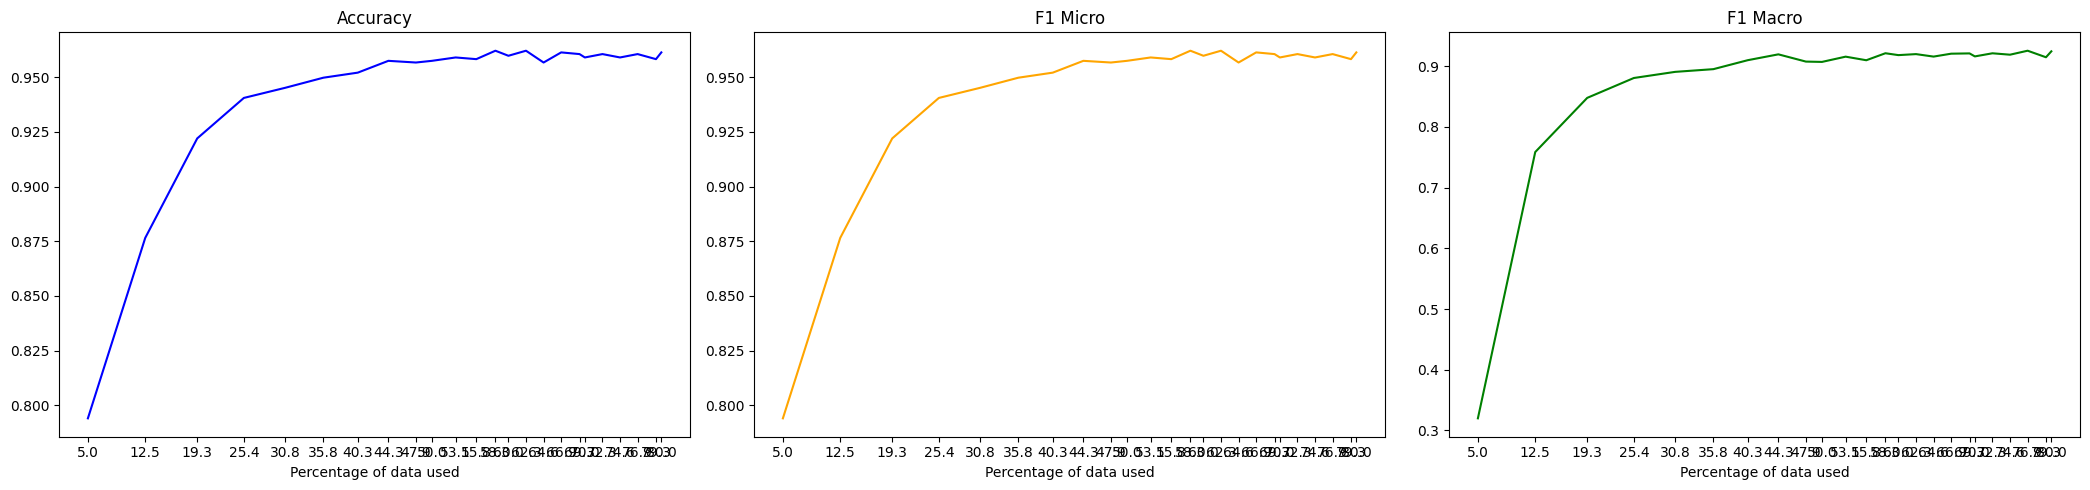

In [25]:
active_learning(seeds[0], 0)